In [77]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from scipy.stats import f_oneway

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA

from IPython.display import display

connectivity_kind = 'tangent'

data  = pd.read_csv('data/julia2018/derivatives/connectivity/dosenbach2010_{}_cagg-between.csv'.format(connectivity_kind.replace(' ','_')))

data['group'] = data['subject'].apply(lambda x: x[:4])

data['connectivity_name'] = data['network_src'] + '_' + data['network_dst']
# data['connectivity'] = data['connectivity'].abs()

# cleanup
data = data.pivot_table(index=['subject', 'group'], columns='connectivity_name', values='connectivity', aggfunc='mean')
# cols = [set(c.split('_')) for c in data.columns
#         if c.split('_')[0] != c.split('_')[1]]
# cc = []
# [cc.append(c) for c in cols if c not in cc]
# cc = [list(c) for c in cc]
# cols = [f'{c[0]}_{c[1]}' for c in cc]

# data = data[cols].reset_index()

# ANOVA
for col in data.columns:
    ols_model = ols(f'{col} ~ C(group)', data=data.reset_index()).fit()
    res = anova_lm(ols_model)
    if res.loc['C(group)', 'PR(>F)'] < .05:
        print(f'[ANOVA] {col} is significant (AVGP != NVGP)')
        display(res)

# MANOVA
manova_model = MANOVA.from_formula('+'.join(data.columns) + '~ C(group)',
                                   data.reset_index())

print('[MANOVA]')
manova_model.mv_test().summary()

[MANOVA]


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Multivariate linear model
================================================================
                                                                
----------------------------------------------------------------
       Intercept         Value    Num DF  Den DF F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda   0.0040 15.0000 16.0000 267.9683 0.0000
         Pillai's trace   0.9960 15.0000 16.0000 267.9683 0.0000
 Hotelling-Lawley trace 251.2203 15.0000 16.0000 267.9683 0.0000
    Roy's greatest root 251.2203 15.0000 16.0000 267.9683 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
           C(group)        Value   Num DF  Den DF F Value Pr > F
----------------------------------------------------------------
             Wilks' lambda 0.4498 15.0000 16.0000  1.3046 0.3014
            Pillai's trace 0.5502 15.0000 16.0000  1.3046 0.3014
    Hotelling-Lawley trace 1.2231 15.0000 16.0000  1.3046 0.3014
       Roy's greatest root 1.2231 15.0000 16.0000  1.3046 0.3014
================================================================

"""

In [78]:
# F oneway anova (using scipy)
import seaborn as sns
import matplotlib.pyplot as plt

data.columns = data.columns.str.replace('_', '\N{left right arrow}')
avgp = data.query('subject.str.contains("AVGP")')
nvgp = data.query('subject.str.contains("NVGP")')


significant_cols = []

for col in data.columns:
    if '\N{left right arrow}' in col:
        f = f_oneway(avgp[col].tolist(), nvgp[col].tolist())
        if f.pvalue < 0.05:
            print(col, f)
            significant_cols.append(col)

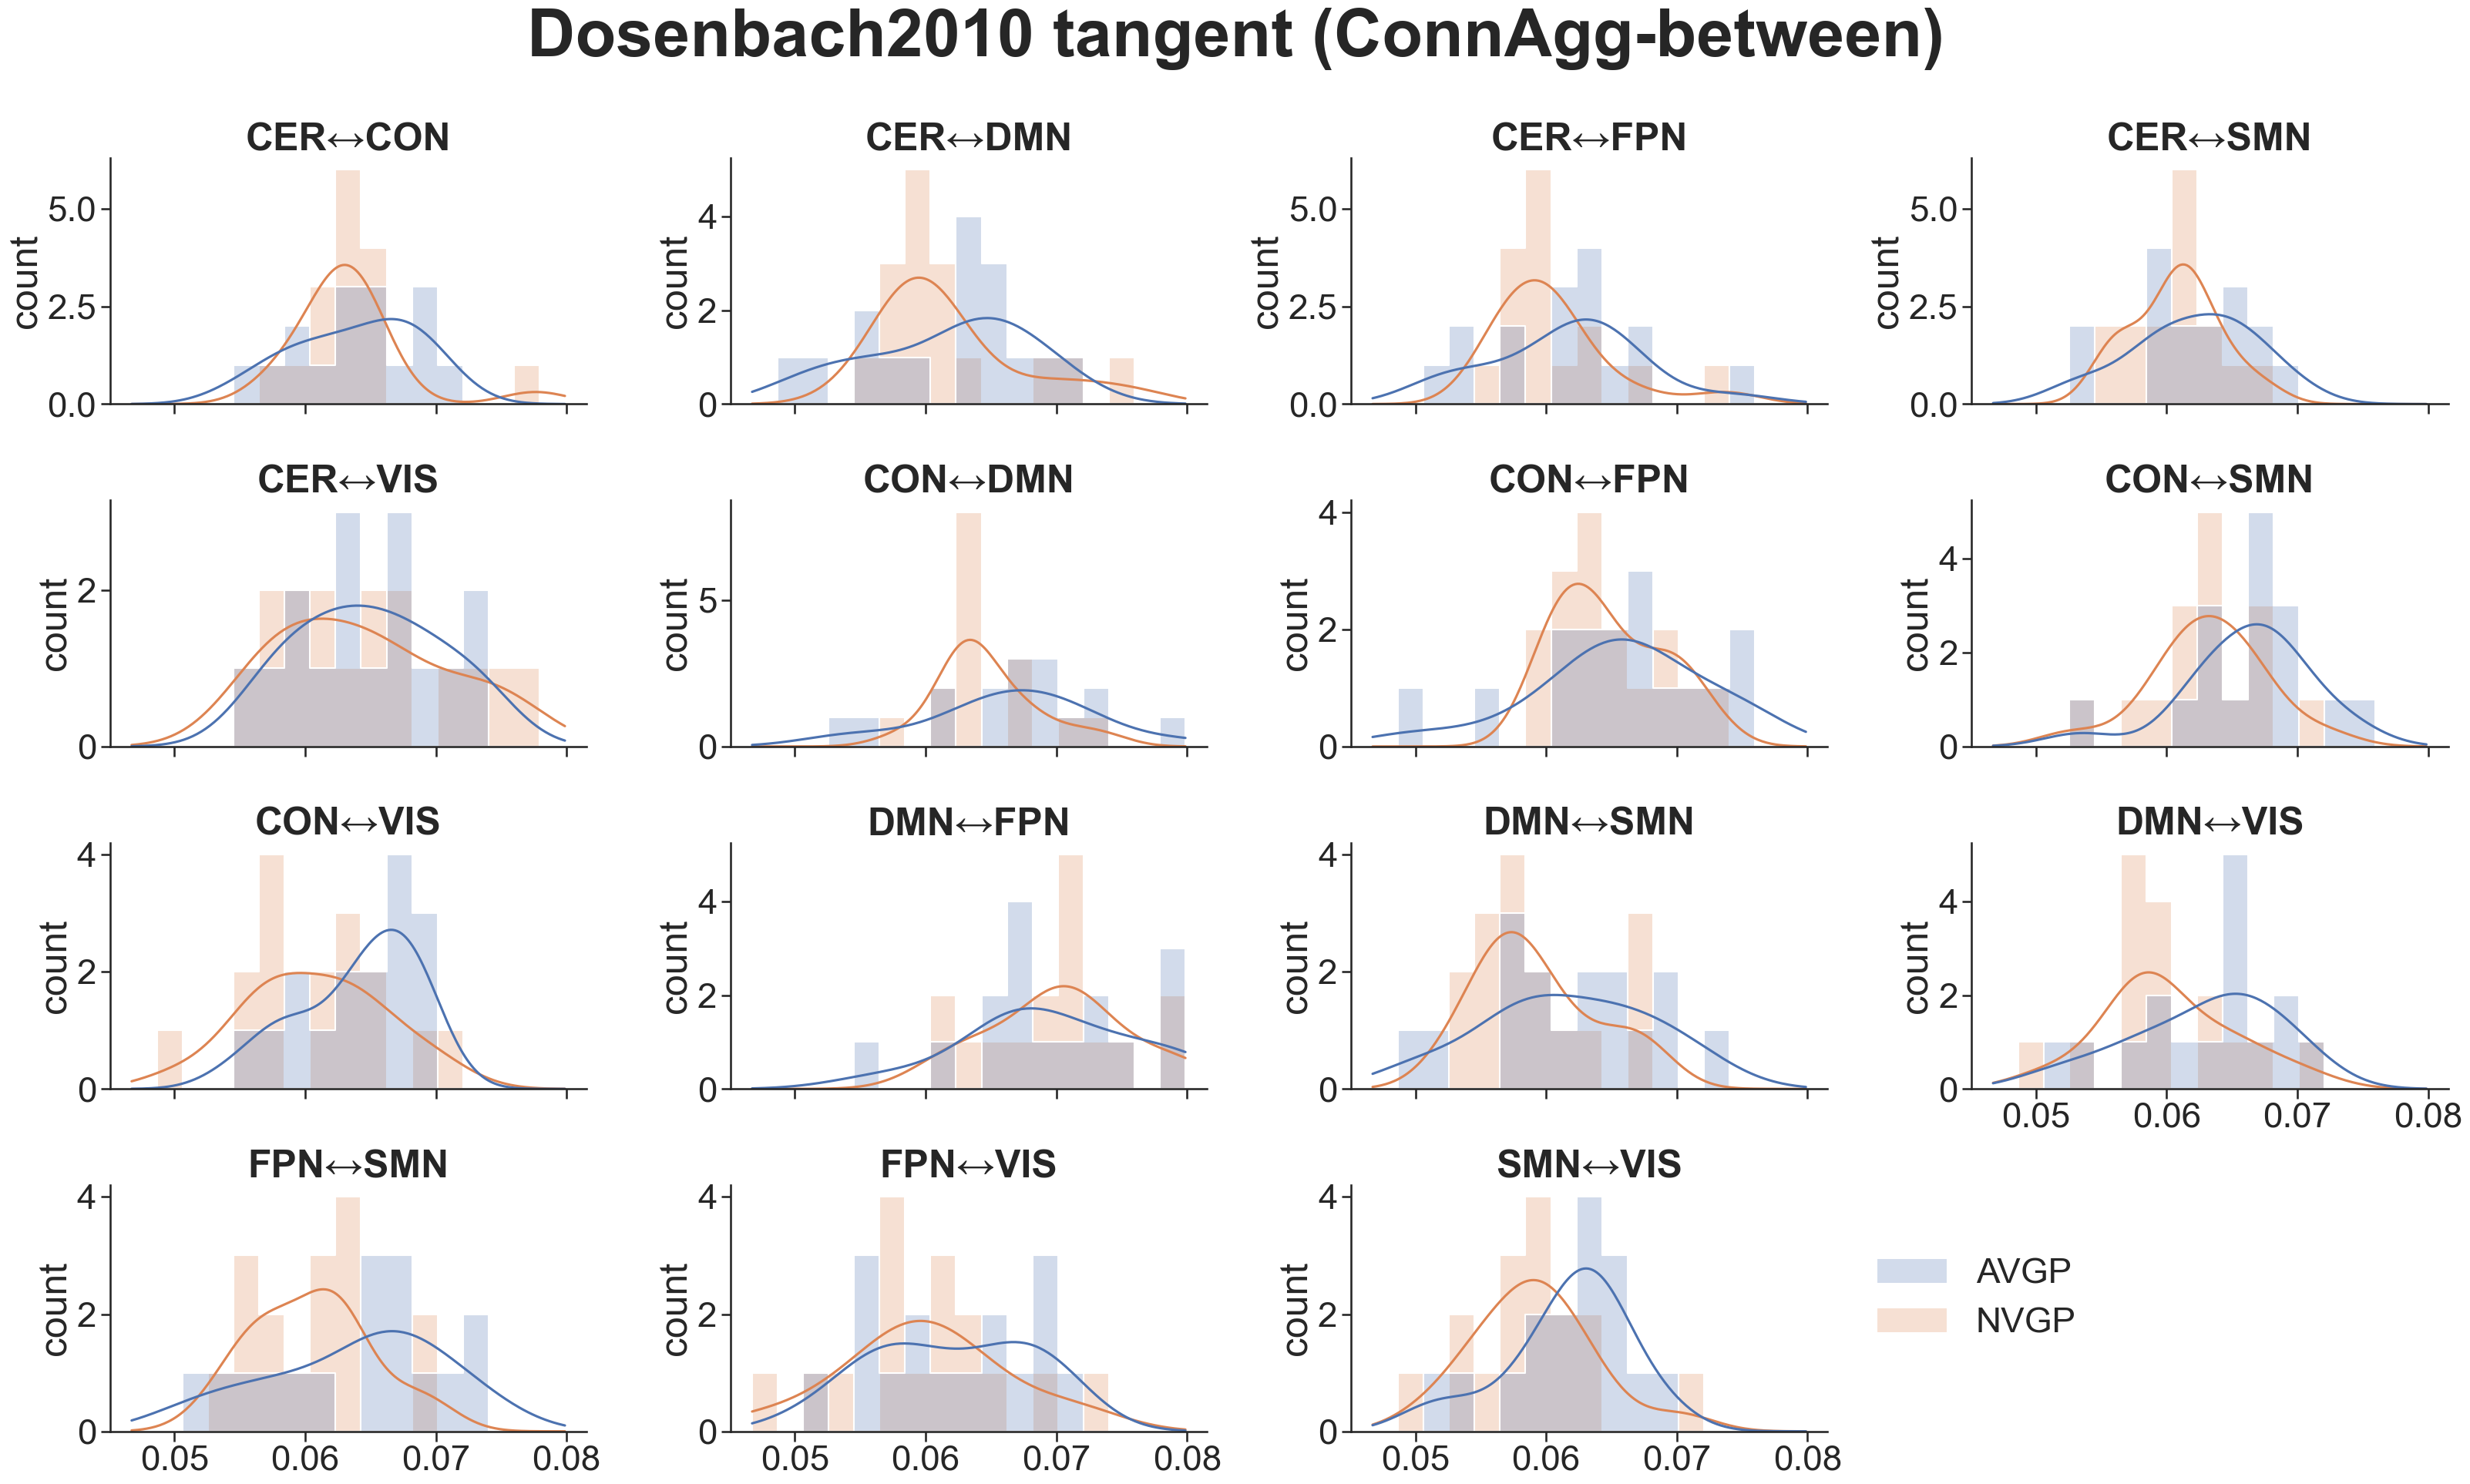

In [79]:
from matplotlib.patches import Rectangle

data_long = data.reset_index().melt(id_vars=['subject', 'group'], var_name='conn', value_name=connectivity_kind)

# \N{downwards arrow}


sns.set_theme('talk', 'ticks', font_scale=2)
g = sns.displot(data=data_long, hue='group',
                x=connectivity_kind,
                col='conn', col_wrap=4,
                element='step',
                facet_kws=dict(sharex=True, sharey=False),
                aspect=1.5, edgecolor='white',
                kind='hist', kde=True, fill=True)

g.set_titles(col_template='{col_name}', fontweight='bold')

for ax in g.axes.flatten():
    if ax.get_title() in significant_cols:
        for s in ax.spines:
            ax.spines[s].set_visible(True)
            ax.spines[s].set_linewidth(8)
            ax.spines[s].set_color('red')
    ax.set_xlabel(None)
    ax.set_ylabel('count')

# move legend of the g to lower right
g._legend.set_bbox_to_anchor([0.83, 0.12])
g._legend.set_title(None)
plt.suptitle(f'Dosenbach2010 {connectivity_kind} (ConnAgg-between)',
             fontweight='bold', fontsize='xx-large')
plt.tight_layout()


# Within Network

[MANOVA]


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Multivariate linear model
===============================================================
                                                               
---------------------------------------------------------------
       Intercept         Value   Num DF  Den DF F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda   0.0071 6.0000 25.0000 583.3847 0.0000
         Pillai's trace   0.9929 6.0000 25.0000 583.3847 0.0000
 Hotelling-Lawley trace 140.0123 6.0000 25.0000 583.3847 0.0000
    Roy's greatest root 140.0123 6.0000 25.0000 583.3847 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           C(group)        Value  Num DF  Den DF F Value Pr > F
---------------------------------------------------------------
             Wilks' lambda 0.8794 6.0000 25.0000  0.5714 0.7492
            Pillai's trace 0.1206 6.0000 25.0000  0.5714 0.7492
    Hotelling-Lawley trace 0.1371 6.0000 25.0000  0.5714 0.7492
       Roy's greatest root 0.1371 6.0000 25.0000  0.5714 0.7492
===============================================================

"""

CER is not significant F_onewayResult(statistic=0.03514140321270374, pvalue=0.8525617982970343)
CON is not significant F_onewayResult(statistic=1.1365826954660476, pvalue=0.29488070731981564)
DMN is not significant F_onewayResult(statistic=0.32894889668389093, pvalue=0.5705536571273992)
FPN is not significant F_onewayResult(statistic=0.09686932621209532, pvalue=0.7577719330481804)
SMN is not significant F_onewayResult(statistic=3.2751192957985666, pvalue=0.08036738326001681)
VIS is not significant F_onewayResult(statistic=0.6826083580104115, pvalue=0.41521269790376736)


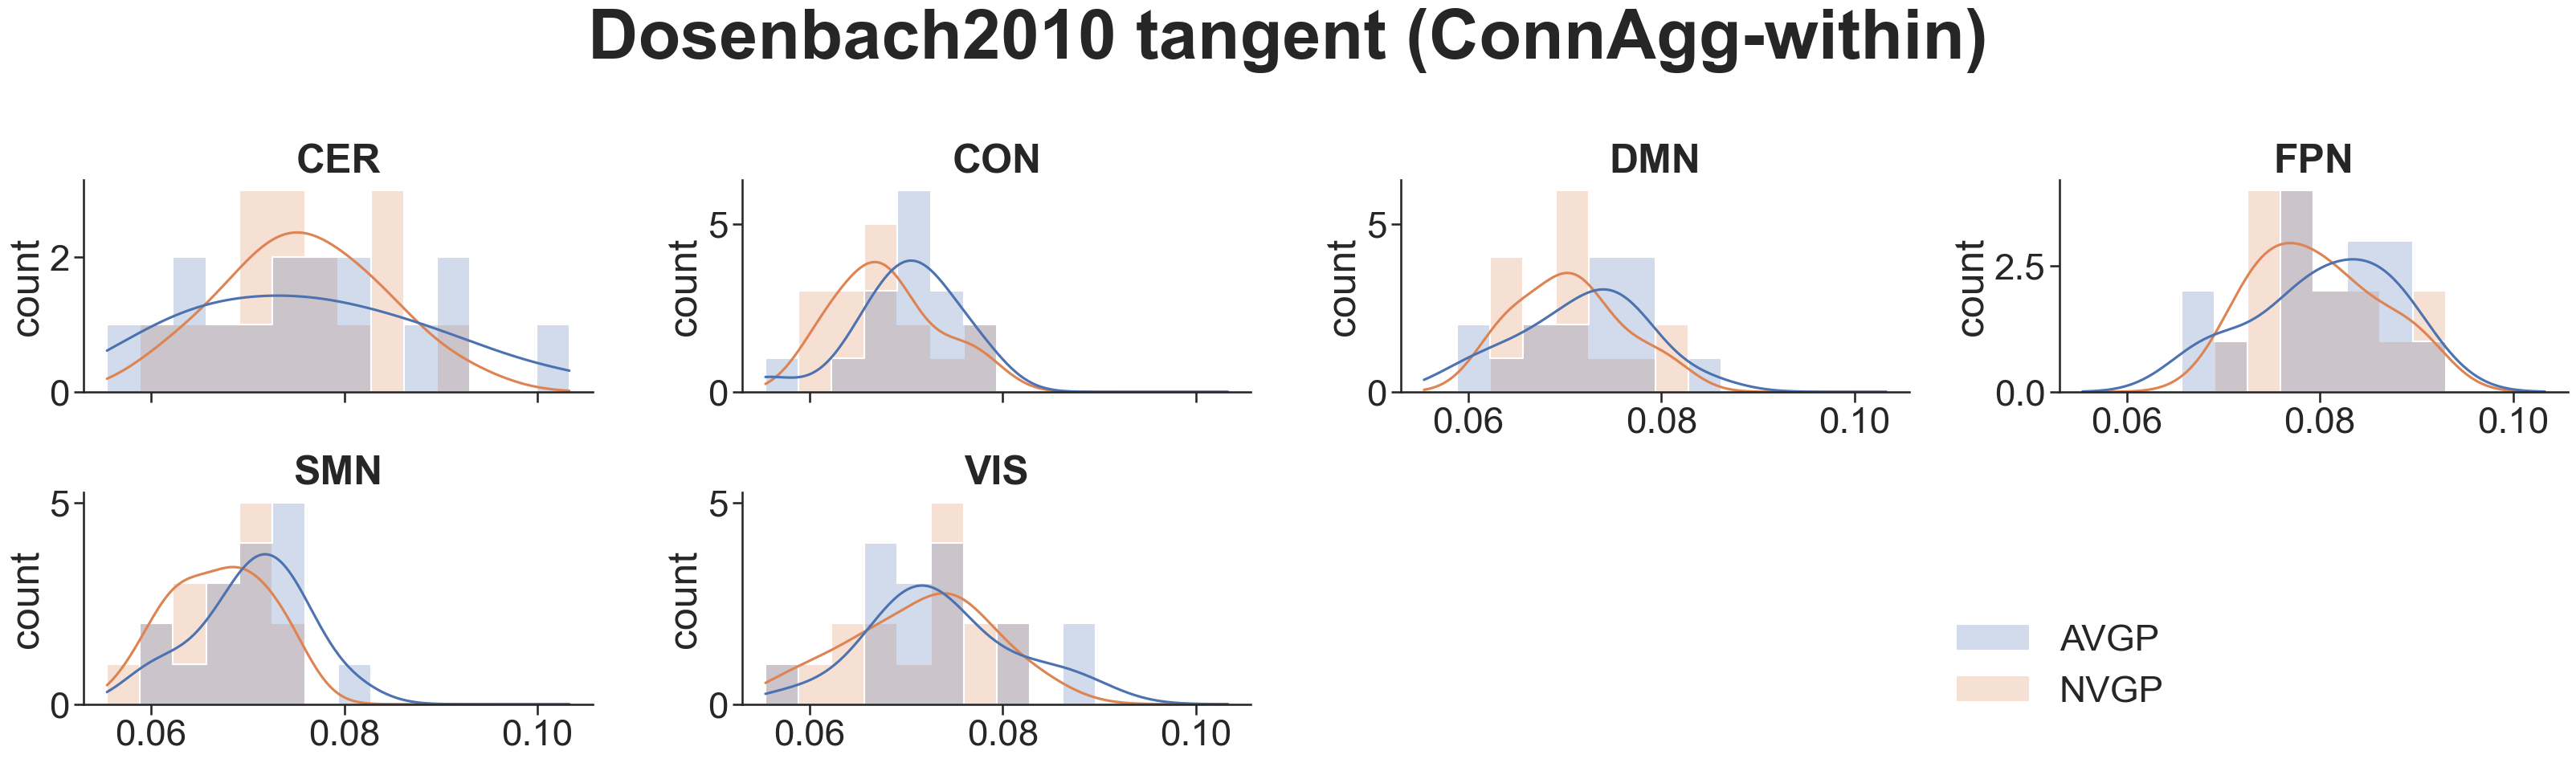

In [80]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from scipy.stats import f_oneway

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA

from IPython.display import display

data  = pd.read_csv('data/julia2018/derivatives/connectivity/dosenbach2010_{}_cagg-within.csv'.format(connectivity_kind.replace(' ','_')))

data['group'] = data['subject'].apply(lambda x: x[:4])

# cleanup
data = data.pivot_table(index=['subject', 'group'], columns='network', values='connectivity', aggfunc='mean')
# cols = [set(c.split('_')) for c in data.columns
#         if c.split('_')[0] != c.split('_')[1]]
# cc = []
# [cc.append(c) for c in cols if c not in cc]
# cc = [list(c) for c in cc]
# cols = [f'{c[0]}_{c[1]}' for c in cc]

# data = data[cols].reset_index()

# ANOVA
for col in data.columns:
    ols_model = ols(f'{col} ~ C(group)', data=data.reset_index()).fit()
    res = anova_lm(ols_model)
    if res.loc['C(group)', 'PR(>F)'] < .05:
        print(f'[ANOVA] {col} is significant (AVGP != NVGP)')
        display(res)

# MANOVA
manova_model = MANOVA.from_formula('+'.join(data.columns) + '~ C(group)',
                                   data.reset_index())

print('[MANOVA]')
display(manova_model.mv_test().summary())

# F oneway anova (using scipy)
import seaborn as sns
import matplotlib.pyplot as plt

avgp = data.query('subject.str.contains("AVGP")')
nvgp = data.query('subject.str.contains("NVGP")')

significant_cols = []

for col in data.columns:
    f = f_oneway(avgp[col].tolist(), nvgp[col].tolist())
    if f.pvalue < 0.05:
        print(col, f)
        significant_cols.append(col)
    else:
        print(f'{col} is not significant', f)


from matplotlib.patches import Rectangle

data_long = data.reset_index().melt(id_vars=['subject', 'group'], var_name='conn', value_name=connectivity_kind)

# \N{downwards arrow}
sns.set_theme('talk', 'ticks', font_scale=2)
g = sns.displot(data=data_long, hue='group',
                x=connectivity_kind,
                col='conn', col_wrap=4,
                element='step',
                facet_kws=dict(sharex=True, sharey=False),
                aspect=1.5, edgecolor='white',
                kind='hist', kde=True, fill=True)

g.set_titles(col_template='{col_name}', fontweight='bold')

for ax in g.axes.flatten():
    if ax.get_title() in significant_cols:
        for s in ax.spines:
            ax.spines[s].set_visible(True)
            ax.spines[s].set_linewidth(8)
            ax.spines[s].set_color('red')
    ax.set_xlabel(None)
    ax.set_ylabel('count')

# move legend of the g to lower right
g._legend.set_bbox_to_anchor([0.83, 0.12])
g._legend.set_title(None)
plt.suptitle(f'Dosenbach2010 {connectivity_kind} (ConnAgg-within)',
             fontweight='bold', fontsize='xx-large')
plt.tight_layout()
